#### Input

In [1]:
#%load_ext nb_black
%load_ext autoreload

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from helpers import plot_class
from helpers import helpfunction as helper

pd.options.display.max_columns = None

### Constants

In [3]:
scale_pot = 6e20
input_dir = "./input/Jun2020/"
output_dir = "./output/nue/datamc/"

In [4]:
data = pd.read_pickle(input_dir + "after_training.pckl")

In [5]:
#data['sideband']['daughters'].query('sample==9 & run>13000')

In [6]:
sideband = False
if sideband:
    beam_on = "sideband"
    master_query = (
        "(contained_fraction>0.9 & preselect & reco_e>1.05 & n_showers_contained>0)"
    )
    data
    del data["on"]
else:
    beam_on = "on"
    master_query = None
    del data["sideband"]
samples = list(data.keys())

In [7]:
run12 = False
run3 = False
if run12 and run3:
    print('Impossible')
if run12:
    data["sideband"]['E1DCNT_wcut'] = 92086705
    data["sideband"]['pot'] = 3.988e+20
    data["off"]['EXT'] = 186993192
    master_query+= ' & (run<13000 | (sample!=2 & sample!=9))'
elif run3:
    data["sideband"]['E1DCNT_wcut'] = 44050047
    data["sideband"]['pot'] = 1.842e+20
    data["off"]['EXT'] = 86991453
    master_query+= ' & (run>13000 | (sample!=2 & sample!=9))'
else:
    if sideband:
        data["sideband"]['E1DCNT_wcut'] = 92086705+44050047
        data["sideband"]['pot'] = 3.988e+20+1.842e+20
    data["off"]['EXT'] = 186993192+86991453
    
print(data[beam_on]['E1DCNT_wcut'],
      data[beam_on]['pot'],
      data["off"]['EXT'])

10866710.0 4.837e+19 273984645


In [8]:
title_str = "MicroBooNE {:.1e} POT, Preliminary".format(data[beam_on]["pot"])

In [9]:
# Redo the categories from scratch:
# Do not use the fid vol of the analyser at all
q_1 = "true_fid_vol & abs(nu_pdg)==12 & nelec>0 & (npi0+npion)>0"
q_10 = "true_fid_vol & abs(nu_pdg)==12 & nelec>0 & nproton==0 & (npi0+npion)==0"
q_11 = "true_fid_vol & abs(nu_pdg)==12 & nelec>0 & nproton>0 & (npi0+npion)==0"
q_2 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & npi0==0"
q_21 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & npi0>0"
q_3 = "true_fid_vol & ~((abs(nu_pdg)==12 & nelec>0) | (abs(nu_pdg)==14 & nmuon>0)) & npi0==0"
q_31 = "true_fid_vol & ~((abs(nu_pdg)==12 & nelec>0) | (abs(nu_pdg)==14 & nmuon>0)) & npi0>0"
q_5 = "true_fid_vol==0"

for s in samples:

    # add new field:
    grouper = ["sample", "Run", "event"]
    data[s]["daughters"]["trk_at_vtx"] = (
        data[s]["daughters"]
        .eval("trk_distance_v<4 & trk_distance_v>=0 & trk_score_v>0.3")
        .groupby(grouper, sort=False)
        .transform(sum)
    )

    if s not in helper.data_samples:
        add_mc_fields = ["nelec", "nmuon", "nu_purity_from_pfp"]
        for true_f in add_mc_fields:
            data[s]["daughters"][true_f] = np.repeat(
                data[s]["mc"][true_f], data[s]["mc"]["n_pfps"]
            )

        data[s]["daughters"]["true_fid_vol"] = np.repeat(
            helper.is_fid(
                data[s]["mc"]["true_nu_vtx_x"],
                data[s]["mc"]["true_nu_vtx_y"],
                data[s]["mc"]["true_nu_vtx_z"],
            ),
            data[s]["mc"]["n_pfps"],
        )

        new_cat = (
            data[s]["daughters"].eval(q_1) * 1
            + data[s]["daughters"].eval(q_10) * 10
            + data[s]["daughters"].eval(q_11) * 11
            + data[s]["daughters"].eval(q_2) * 2
            + data[s]["daughters"].eval(q_21) * 21
            + data[s]["daughters"].eval(q_3) * 3
            + data[s]["daughters"].eval(q_31) * 31
            + data[s]["daughters"].eval(q_5) * 5
        )
        data[s]["daughters"]["category"] = new_cat

        cosmic = (data[s]["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            data[s]["daughters"]["category"] != 5
        )
        data[s]["daughters"].loc[cosmic, "category"] = 4

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [10]:
print(list(data["nu"]["daughters"].keys()))

['reco_nu_vtx_y', 'backtracked_start_x', 'shr_tkfit_dedx_y_v', 'backtracked_purity', 'trk_llr_pid_score_v', 'shr_tkfit_gap10_dedx_y_v', 'hits_ratio', 'secondshower_Y_nhit', 'shr_tkfit_nhits_v', 'contained_fraction', 'reco_nu_vtx_z', 'shr_tkfit_2cm_dedx_Y', 'NeutrinoEnergy2', 'trk_len_v', 'shr_tkfit_2cm_nhits_Y', 'pfp_generation_v', 'backtracked_pz', 'n_tracks_contained', 'trk_sce_start_z_v', 'reco_nu_vtx_sce_x', 'backtracked_completeness', 'shr_energy_y_v', 'trk_sce_end_x_v', 'shr_tkfit_dedx_nhits_y_v', 'trk_sce_end_y_v', 'trk_score_v', 'backtracked_py', 'backtracked_start_y', 'CosmicDirAll3D', 'CosmicIPAll3D', 'backtracked_e', 'trk_sce_end_z_v', 'reco_nu_vtx_sce_y', 'SliceCaloEnergy2', 'backtracked_pdg', 'n_showers', 'sub', 'n_pfps', 'pfp_shr_daughters_v', 'reco_nu_vtx_x', 'backtracked_px', 'reco_nu_vtx_sce_z', 'shr_dist_v', 'pfnhits', 'trk_distance_v', 'shr_tkfit_2cm_nhits_V', 'trk_phi_v', 'trk_sce_start_x_v', 'shr_phi_v', 'n_tracks', 'shr_theta_v', 'trk_sce_start_y_v', 'n_showers_co

In [11]:
plotter = plot_class.Plotter(
    data,
    signal="nue",
    genie_version="mcc9.1",
    sideband=sideband,
    master_query=master_query,
    load_syst=["weightsFlux", "weightsGenie"],
)
del data
gc.collect()

Using the spline weights as in MCC9.1 Genie V3 tune 1
All plots are scaled to 4.84e+19 POT, Beam_on data corresponds to 4.84e+19 POT
Loaded all daughter dataframes.
Started loading systematic weights.
Loaded all universes for weightsFlux.
Loaded all universes for weightsGenie.
Initialisation completed!


0

### Plots

#### Additions to signal sample plots

In [12]:
# purity for every step per cat
cats = {2: 11, 1: 10, 3: 1}
selectors = ["daughter==0", "e_candidate & preselect", "e_candidate & select"]  # q_s
labs = ["NeutrinoID", "Pre-selection", "Selection"]

for selector, lab in zip(selectors, labs):
    ratio, purity = plotter.get_ratio_and_purity(selector, return_syst_err=True)
    print("{} \tPurity: {:.2%}+-{:.2%}".format(lab, *purity))
    print("{} \tRatio: {:.2f}+-{:.2f}".format(lab, ratio[0], ratio[2]))

NeutrinoID 	Purity: 0.13%+-0.00%
NeutrinoID 	Ratio: 0.98+-0.13
Pre-selection 	Purity: 5.72%+-0.04%
Pre-selection 	Ratio: 0.91+-0.13
Selection 	Purity: 52.07%+-0.98%
Selection 	Ratio: 0.70+-0.21


#### Data/MC comparison

Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 14. 	#entries 33946
MC category: $\nu_e$ CC 0$\pi$0p: 5.6 	#entries 10448
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 23. 	#entries 43928
MC category: $\nu_{\mu}$ CC other: 129. 	#entries 19538
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 225. 	#entries 41479
MC category: $\nu$ NC: 55. 	#entries 19730
MC category: $\nu$ NC $\pi^{0}$: 298. 	#entries 30152
MC category: Cosmic: 119. 	#entries 15464
MC category: Out of FV: 237. 	#entries 17657
MC category: Out of Cryo: 101. 	#entries 1165
Showing LEE model
Systematic vatiation weightsFlux has 100 universes.
Systematic vatiation weightsGenie has 100 universes.
Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 14. 	#entries 33946
MC category: $\nu_e$ CC 0$\pi$0p: 5.6 	#entries 10448
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 23. 	#entries 43928
MC category: $\nu_{\mu}$ CC other: 129. 	#entries 19538
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 225. 	#entries 41479
MC cate

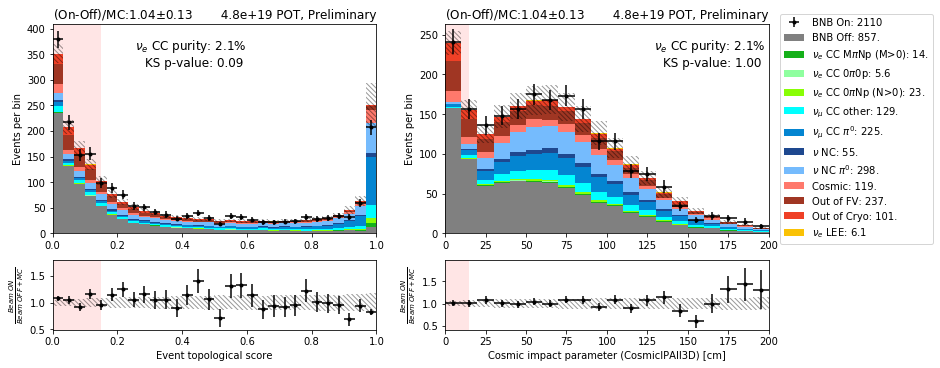

In [13]:
if not sideband:
    query = (
        "(reco_fid_vol & slpdg==12 & contained_fraction>0.4 & optical_filter & daughter==0)"
    )

    fig, ax = plt.subplots(
        ncols=2,
        nrows=2,
        figsize=(8 * plotter.gr, 5),
        gridspec_kw={"height_ratios": [3, 1]},
        constrained_layout=True,
    )

    ax[0][0].axvspan(0, 0.15, facecolor="red", alpha=0.1)
    ax[1][0].axvspan(0, 0.15, facecolor="red", alpha=0.1)
    ax[0][1].axvspan(0, 15, facecolor="red", alpha=0.1)
    ax[1][1].axvspan(0, 15, facecolor="red", alpha=0.1)

    ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
        ax.T[0],
        "topological_score",
        r"Event topological score",
        N_bins=30,
        x_min=0,
        x_max=1,
        query=query,
        legend=False,
        show_syst=True,
        title_str=title_str.split("NE")[-1],
        kind="cat",
    )
    ax[0][0].text(
        ax[0][0].get_xlim()[1] * 0.6,
        ax[0][0].get_ylim()[1] * 0.8,
        r"$\nu_e$"
        + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
        horizontalalignment="right",
        fontsize=12,
    )

    ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
        ax.T[1],
        "CosmicIPAll3D",
        r"Cosmic impact parameter (CosmicIPAll3D) [cm]",
        N_bins=20,
        x_min=0,
        x_max=200,
        query=query,
        show_syst=True,
        legend=True,
        title_str=title_str.split("NE")[-1],
        kind="cat",
    )
    ax[0][1].text(
        ax[0][1].get_xlim()[1] * 0.99,
        ax[0][1].get_ylim()[1] * 0.8,
        r"$\nu_e$"
        + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
        horizontalalignment="right",
        fontsize=12,
    )

    fig.savefig(output_dir + "topo_impact.pdf", bbox_inches="tight")

Systematics only supported for one row per event
Ratio and purity are obtained
MC category: $p$: 752. 	#entries 109546
MC category: $\mu$: 6923. 	#entries 744504
MC category: $\pi^{\pm}$: 993. 	#entries 228831
MC category: $\gamma$: 1279. 	#entries 207084
MC category: $K$: 4.1 	#entries 867
MC category: Cosmic: 1822. 	#entries 231753
MC category: $e$: 52. 	#entries 90709
Showing LEE model
Systematics only supported for one row per event
Ratio and purity are obtained
MC category: $p$: 2.1 	#entries 463
MC category: $\mu$: 22. 	#entries 3383
MC category: $\pi^{\pm}$: 9.2 	#entries 2661
MC category: $\gamma$: 487. 	#entries 73941
MC category: $K$: 0.091 	#entries 12
MC category: Cosmic: 109. 	#entries 20245
MC category: $e$: 34. 	#entries 63194
Showing LEE model


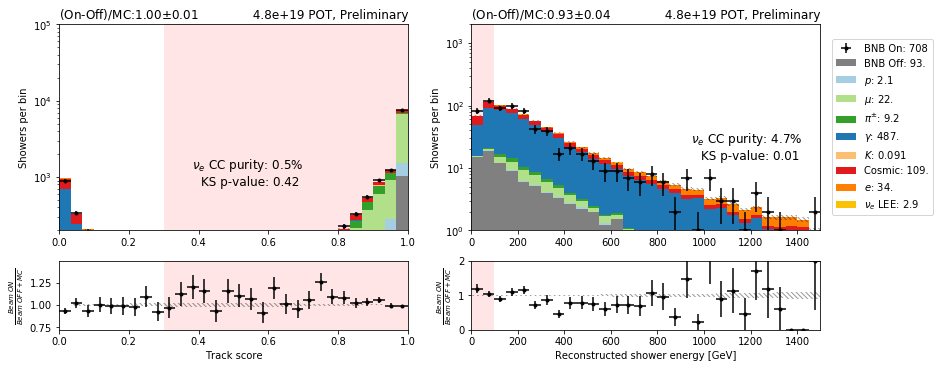

In [14]:
if not sideband:
    query = "optical_filter & \
             reco_fid_vol & \
             shr_energy_y_v>0 & \
             topological_score > 0.15 & \
             pfp_generation_v==2 & \
             trk_llr_pid_score_v>0.4 & \
             shr_tkfit_4cm_dedx_wm_v>0 & \
             shr_tkfit_dedx_y_v >0"


    # the cosmic IP variables demand somehow that there is a shower in the event, therefore, they are left out of this cut.
    fig, ax = plt.subplots(
        ncols=2,
        nrows=2,
        figsize=(8 * plotter.gr, 5),
        gridspec_kw={"height_ratios": [3, 1]},
        constrained_layout=True,
    )

    ax[0][0].axvspan(0.3, 1, facecolor="red", alpha=0.1)
    ax[1][0].axvspan(0.3, 1, facecolor="red", alpha=0.1)
    ax[0][1].axvspan(0, 100, facecolor="red", alpha=0.1)
    ax[1][1].axvspan(0, 100, facecolor="red", alpha=0.1)

    ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
        ax.T[0],
        "trk_score_v",
        r"Track score",
        N_bins=30,
        x_min=0,
        x_max=1,
        query=query,
        legend=False,
        title_str=title_str.split("NE")[-1],
        kind="pdg",
        y_label="Showers per bin",
    )
    ax[0][0].text(
        ax[0][0].get_xlim()[1] * 0.7,
        ax[0][0].get_ylim()[1] * 0.1,
        r"$\nu_e$"
        + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
        horizontalalignment="right",
        fontsize=12,
    )

    query += " & (trk_score_v<0.3) & \
                 slpdg==12 & \
                 contained_fraction>0.4 & \
                 CosmicIPAll3D>30 & \
                 CosmicDirAll3D>-0.98 & \
                 CosmicDirAll3D<0.98"

    ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
        ax.T[1],
        "shr_energy_y_v",
        r"Reconstructed shower energy [GeV]",
        N_bins=30,
        x_min=0,
        x_max=1500,
        query=query,
        legend=True,
        title_str=title_str.split("NE")[-1],
        kind="pdg",
        y_label="Showers per bin",
    )
    ax[0][1].text(
        ax[0][1].get_xlim()[1] * 0.95,
        ax[0][1].get_ylim()[1] * 0.1,
        r"$\nu_e$"
        + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
        horizontalalignment="right",
        fontsize=12,
    )

    ax[0][0].set_ylim(200, 1e5)
    ax[0][0].set_yscale("log")
    ax[0][1].set_ylim(1, 2e3)
    ax[0][1].set_yscale("log")

    fig.savefig(output_dir + "trk_she.pdf", bbox_inches="tight")

Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Systematic vatiation weightsFlux has 100 universes.
Systematic vatiation weightsGenie has 100 universes.
Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Systematic vatiation weightsFlux has 100 universes.
Systematic vatiation weightsGenie has 100 universes.


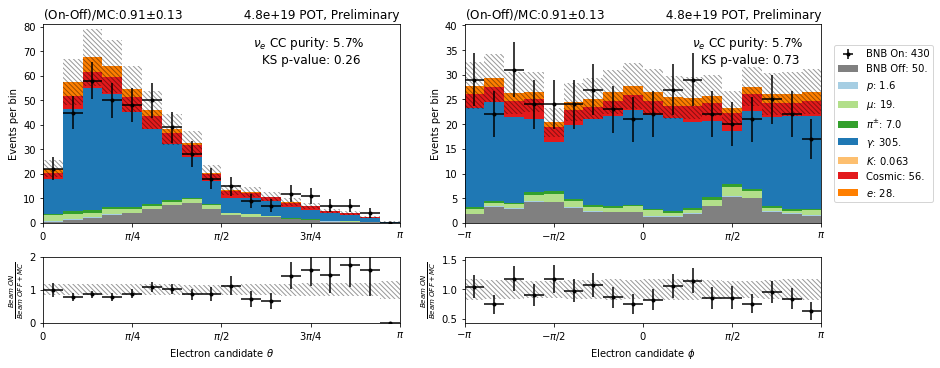

In [15]:
query = "(preselect & e_candidate)"

fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_theta_v",
    r"Electron candidate $\theta$",
    N_bins=18,
    x_min=0,
    x_max=np.pi,
    query=query,
    legend=False,
    show_lee=False,
    show_syst=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.9,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)
x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)


ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_phi_v",
    r"Electron candidate $\phi$",
    N_bins=18,
    x_min=-np.pi,
    x_max=np.pi,
    query=query,
    legend=True,
    show_lee=False,
    show_syst=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
    y_max_scaler = 1.1
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.9,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)


fig.savefig(output_dir + "theta_phi.pdf", bbox_inches="tight")

## Shower fields
1. feature shr_dist_v (0.406786)
2. feature shr_moliere_avg_v (0.115516)
3. feature shr_tkfit_dedx_y_v (0.103206)
4. feature shr_tkfit_2cm_dedx_Y (0.088309)
5. feature shr_tkfit_4cm_dedx_wm_v (0.080856)
6. feature shr_tkfit_gap10_dedx_y_v (0.078377)
7. feature shr_subclusters_v (0.048331)
8. feature secondshower_Y_nhit (0.046542)
9. feature shr_tkfit_hitratio_v (0.032077)

Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model
Systematic vatiation weightsFlux has 100 universes.
Systematic vatiation weightsGenie has 100 universes.
Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Systematic vatiation weightsFlux has 100 universes.
Systematic vatiation weightsGenie has 100 universes.


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


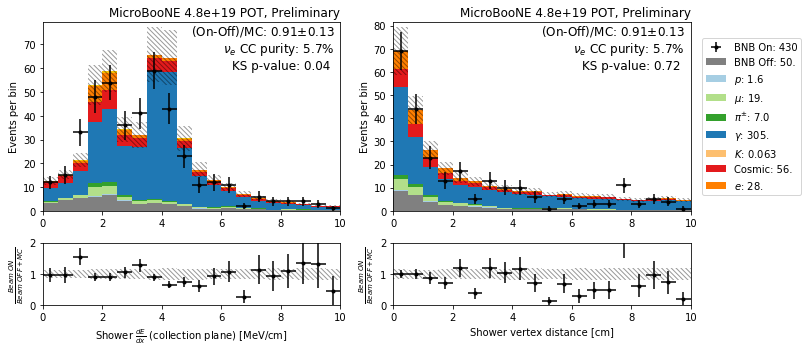

In [16]:
# Neutrino 2020

fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(7 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_tkfit_dedx_y_v",
    r"Shower $\frac{dE}{dx}$ (collection plane) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
    show_syst=True,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_dist_v",
    "Shower vertex distance [cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
    show_lee=False,
    show_syst=True,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)

[x.set_title("", loc="left") for x in ax[0]]
[x.set_ylim(0.0, 2) for x in ax[1]]

fig.tight_layout()
fig.savefig(output_dir + "e_cand_neutrino_sideband.pdf", bbox_inches="tight")

Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model
Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model
Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


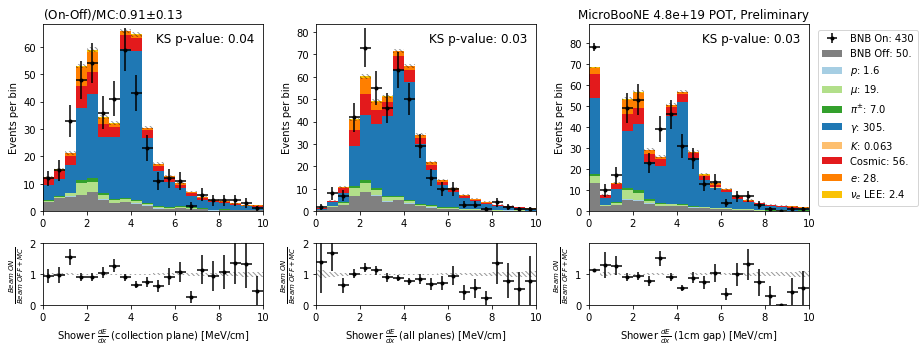

In [17]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_tkfit_dedx_y_v",
    r"Shower $\frac{dE}{dx}$ (collection plane) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_tkfit_4cm_dedx_wm_v",
    r"Shower $\frac{dE}{dx}$ (all planes) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "shr_tkfit_gap10_dedx_y_v",
    r"Shower $\frac{dE}{dx}$ (1cm gap) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.98,
    ax[0][2].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")

fig.tight_layout()
fig.savefig(output_dir + "e_cand_dedx.pdf", bbox_inches="tight")

Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model


/home/wouter/Public/searchingfornues/helpers/plot_class.py:425: RuntimeWarning: divide by zero encountered in double_scalars
  sc_err = e / v
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/matplotlib/patches.py:716: RuntimeWarning: invalid value encountered in double_scalars
  self._y1 = self._y0 + self._height
/home/wouter/Public/searchingfornues/helpers/plot_class.py:447: RuntimeWarning: invalid value encountered in true_divide
  y_min_r = max(0, min((bins[-1] - err_on) / val) * 0.9)
/home/wouter/Public/searchingfornues/helpers/plot_class.py:448: RuntimeWarning: invalid value encountered in true_divide
  y_max_r = min(2, max((bins[-1] + err_on) / val) * 1.1)
/home/wouter/Public/searchingfornues/helpers/plot_class.py:454: RuntimeWarning: invalid value encountered in true_divide
  bins[-1] / val,
/home/wouter/Public/searchingfornues/helpers/plot_class.py:456: RuntimeWarning: invalid value encountered in true_divide
  yerr=err_on / val,


Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model
Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model


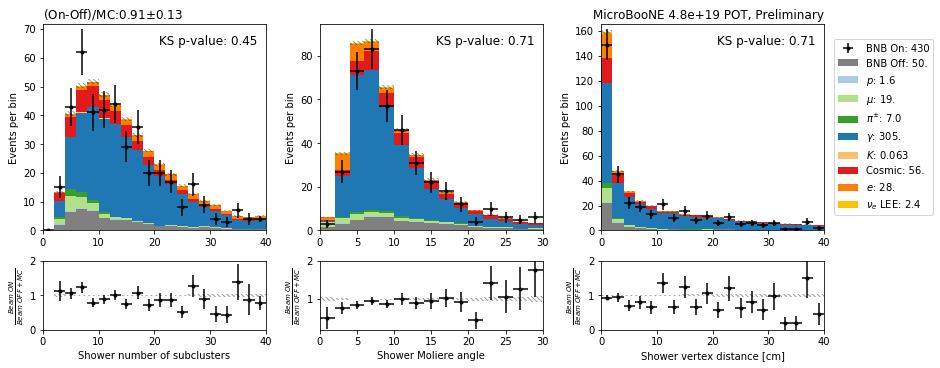

In [18]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_subclusters_v",
    r"Shower number of subclusters",
    N_bins=20,
    x_min=0,
    x_max=40,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_moliere_avg_v",
    r"Shower Moliere angle",
    N_bins=15,
    x_min=0,
    x_max=30,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "shr_dist_v",
    "Shower vertex distance [cm]",
    N_bins=20,
    x_min=0,
    x_max=40,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.98,
    ax[0][2].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")

fig.savefig(output_dir + "e_cand_muonrejection.pdf", bbox_inches="tight")

Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model
Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model
Ratio and purity are obtained
MC category: $p$: 1.6 	#entries 329
MC category: $\mu$: 19. 	#entries 2842
MC category: $\pi^{\pm}$: 7.0 	#entries 1896
MC category: $\gamma$: 305. 	#entries 44245
MC category: $K$: 0.063 	#entries 8
MC category: Cosmic: 56. 	#entries 9391
MC category: $e$: 28. 	#entries 54613
Showing LEE model


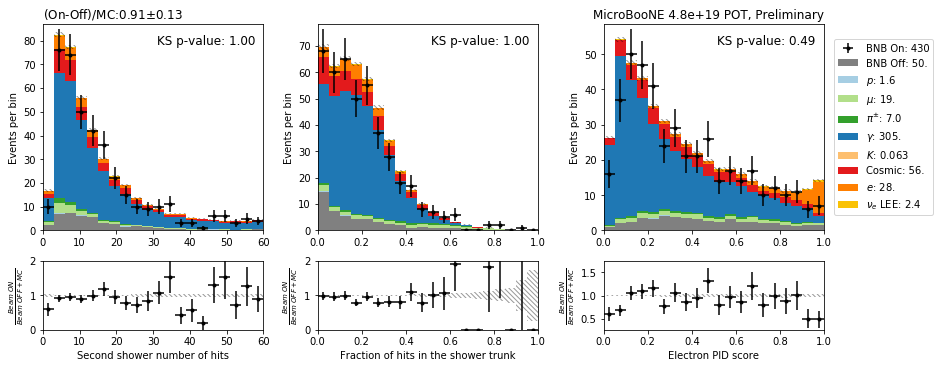

In [19]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "secondshower_Y_nhit",
    "Second shower number of hits",
    N_bins=20,
    x_min=0,
    x_max=60,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_tkfit_hitratio_v",
    r"Fraction of hits in the shower trunk",
    N_bins=20,
    x_min=0,
    x_max=1,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "score",
    r"Electron PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg"
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.98,
    ax[0][2].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")

fig.savefig(output_dir + "e_cand_second_score.pdf", bbox_inches="tight")

## Other daughter fields
1. feature trk_llr_pid_score_v (0.382910)
2. feature trk_distance_v (0.201966)
3. feature e_candidate_anglediff (0.081999)
4. feature trk_proton_hypothesis_ratio_v (0.071988)
5. feature trk_score_v (0.068836)
6. feature trk_muon_hypothesis_ratio_v (0.067883)
7. feature pfp_shr_daughters_v (0.050025)
8. feature pfp_generation_v (0.037862)
9. feature pfp_trk_daughters_v (0.036532)

Systematics only supported for one row per event
Ratio and purity are obtained
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $\gamma$: 346. 	#entries 56033
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $e$: 19. 	#entries 31019
Showing LEE model
Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 9.0 	#entries 21513
MC category: $\nu_e$ CC 0$\pi$0p: 3.2 	#entries 6001
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 15. 	#entries 28656
MC category: $\nu_{\mu}$ CC other: 36. 	#entries 5828
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 129. 	#entries 23860
MC category: $\nu$ NC: 14. 	#entries 4950
MC category: $\nu$ NC $\pi^{0}$: 143. 	#entries 14365
MC category: Cosmic: 34. 	#entries 5100
MC category: Out of FV: 29. 	#entries 2987
MC category: Out of Cryo: 5.6 	#entries 64
Showing LEE model


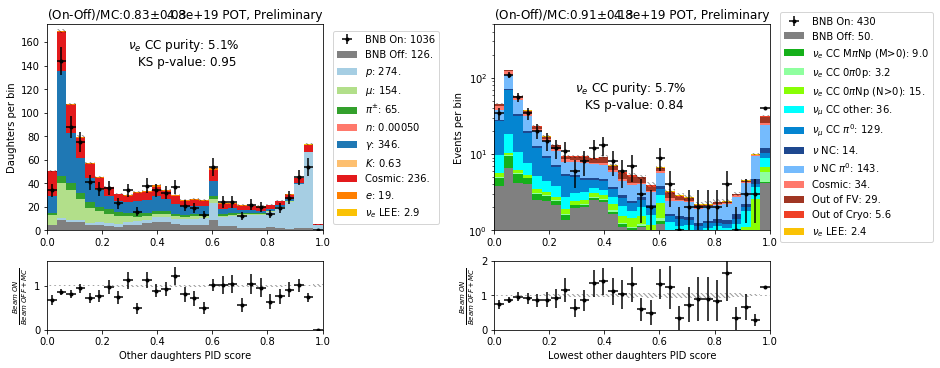

In [20]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "score",
    "Other daughters PID score",
    N_bins=29,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
    y_label="Daughters per bin",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.7,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "score_other_min",
    "Lowest other daughters PID score",
    N_bins=29,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.7,
    ax[0][1].get_ylim()[1] * 0.3,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_ylim(1, 500)
ax[0][1].set_yscale("log")

fig.savefig(output_dir + "pre_daughter_pid.pdf", bbox_inches="tight")

Systematics only supported for one row per event
Ratio and purity are obtained
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $\gamma$: 346. 	#entries 56033
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $e$: 19. 	#entries 31019
Showing LEE model
Systematics only supported for one row per event
Ratio and purity are obtained
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $\gamma$: 346. 	#entries 56033
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $e$: 19. 	#entries 31019
Showing LEE model
Systematics only supported for one row per event
Ratio and purity are obtained
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 273

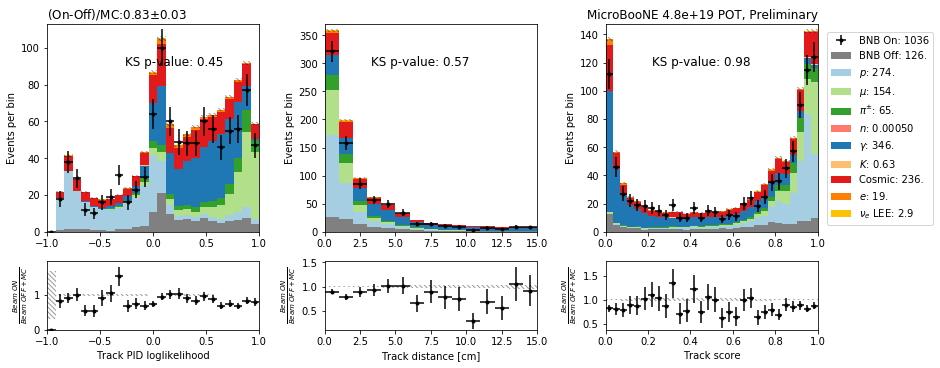

In [21]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_llr_pid_score_v",
    "Track PID loglikelihood",
    N_bins=25,
    x_min=-1,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str="",
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.7,
    ax[0][0].get_ylim()[1] * 0.8,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_distance_v",
    "Track distance [cm]",
    N_bins=15,
    x_min=0,
    x_max=15,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str="",
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.7,
    ax[0][1].get_ylim()[1] * 0.8,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_score_v",
    "Track score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.7,
    ax[0][2].get_ylim()[1] * 0.8,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")


fig.savefig(output_dir + "pre_daughter_1.pdf", bbox_inches="tight")

Systematics only supported for one row per event
Ratio and purity are obtained
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $\gamma$: 346. 	#entries 56033
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $e$: 19. 	#entries 31019
Showing LEE model
Systematics only supported for one row per event
Ratio and purity are obtained
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 27364
MC category: $\pi^{\pm}$: 65. 	#entries 24820
MC category: $n$: 0.00050 	#entries 1
MC category: $\gamma$: 346. 	#entries 56033
MC category: $K$: 0.63 	#entries 231
MC category: Cosmic: 236. 	#entries 62098
MC category: $e$: 19. 	#entries 31019
Showing LEE model
Systematics only supported for one row per event
Ratio and purity are obtained
MC category: $p$: 274. 	#entries 91650
MC category: $\mu$: 154. 	#entries 273

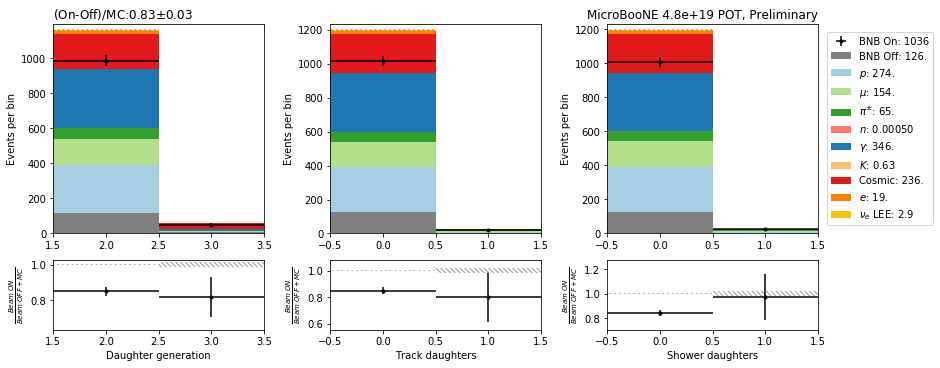

In [22]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "pfp_generation_v",
    "Daughter generation",
    N_bins=2,
    x_min=1.5,
    x_max=3.5,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str="",
    kind="pdg",
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "pfp_trk_daughters_v",
    "Track daughters",
    N_bins=2,
    x_min=-0.5,
    x_max=1.5,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str="",
    kind="pdg",
)
ax[0][1].set_title("", loc="left")

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "pfp_shr_daughters_v",
    "Shower daughters",
    N_bins=2,
    x_min=-0.5,
    x_max=1.5,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
)
ax[0][2].set_title("", loc="left")

fig.savefig(output_dir + "pre_daughter_2.pdf", bbox_inches="tight")

## Combined BDT
1. feature score (0.623621)
2. feature score_other_mean (0.188310)
3. feature n_showers (0.061185)
4. feature score_other_min (0.043890)
5. feature score_other_max (0.040488)
6. feature n_pfp_farvtx (0.023708)
7. feature contained_fraction (0.018798)

Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 9.0 	#entries 21513
MC category: $\nu_e$ CC 0$\pi$0p: 3.2 	#entries 6001
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 15. 	#entries 28656
MC category: $\nu_{\mu}$ CC other: 36. 	#entries 5828
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 129. 	#entries 23860
MC category: $\nu$ NC: 14. 	#entries 4950
MC category: $\nu$ NC $\pi^{0}$: 143. 	#entries 14365
MC category: Cosmic: 34. 	#entries 5100
MC category: Out of FV: 29. 	#entries 2987
MC category: Out of Cryo: 5.6 	#entries 64
Showing LEE model
Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 9.0 	#entries 21513
MC category: $\nu_e$ CC 0$\pi$0p: 3.2 	#entries 6001
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 15. 	#entries 28656
MC category: $\nu_{\mu}$ CC other: 36. 	#entries 5828
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 129. 	#entries 23860
MC category: $\nu$ NC: 14. 	#entries 4950
MC category: $\nu$ NC $\pi^{0}$: 143. 	#entries 14365
MC category: Cosmic: 34. 	#ent

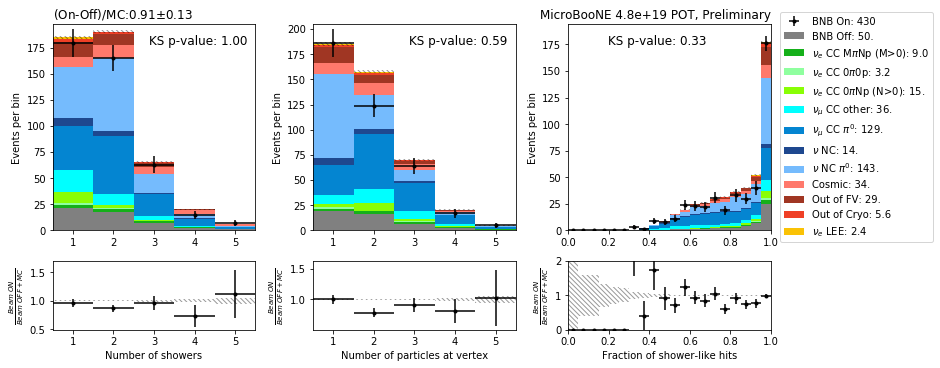

In [23]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "n_showers",
    r"Number of showers",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="cat",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "n_pfpvtx",
    r"Number of particles at vertex",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="cat",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "hits_ratio",
    r"Fraction of shower-like hits",
    N_bins=20,
    x_min=0,
    x_max=1,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat",
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.7,
    ax[0][2].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")

fig.savefig(output_dir + "event_bdt_input.pdf", bbox_inches="tight")

Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 9.0 	#entries 21513
MC category: $\nu_e$ CC 0$\pi$0p: 3.2 	#entries 6001
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 15. 	#entries 28656
MC category: $\nu_{\mu}$ CC other: 36. 	#entries 5828
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 129. 	#entries 23860
MC category: $\nu$ NC: 14. 	#entries 4950
MC category: $\nu$ NC $\pi^{0}$: 143. 	#entries 14365
MC category: Cosmic: 34. 	#entries 5100
MC category: Out of FV: 29. 	#entries 2987
MC category: Out of Cryo: 5.6 	#entries 64
Systematic vatiation weightsFlux has 100 universes.
Systematic vatiation weightsGenie has 100 universes.
Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 2.9 	#entries 6827
MC category: $\nu_e$ CC 0$\pi$0p: 1.8 	#entries 3359
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 9.0 	#entries 17676
MC category: $\nu_{\mu}$ CC other: 2.3 	#entries 321
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 1.6 	#entries 302
MC category: $\nu$ NC: 0.68 	#entries 235
MC

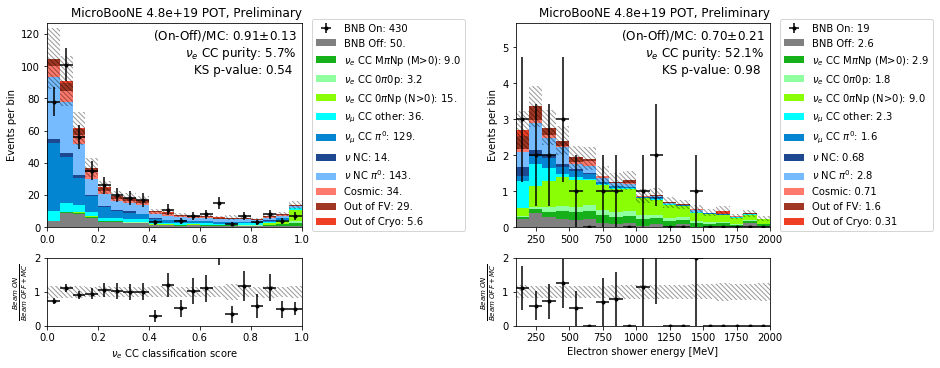

In [24]:
%autoreload
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "score_event",
    r"$\nu_e$ CC classification score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="(preselect & e_candidate)",
    legend=True,
    title_str=title_str,
    kind="cat",
    show_lee=False,
    show_syst=True
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)


ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_energy_y_v",
    "Electron shower energy [MeV]",
    N_bins=19,
    x_min=100,
    x_max=2000,
    query="(select & e_candidate)",
    legend=True,
    title_str=title_str,
    y_max_scaler=1.2,
    kind="cat",
    show_lee=False,
    show_syst=True,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)

[x.set_title("", loc="left") for x in ax[0]]
[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "event_bdt.pdf", bbox_inches="tight")

Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 9.0 	#entries 21513
MC category: $\nu_e$ CC 0$\pi$0p: 3.2 	#entries 6001
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 15. 	#entries 28656
MC category: $\nu_{\mu}$ CC other: 36. 	#entries 5828
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 129. 	#entries 23860
MC category: $\nu$ NC: 14. 	#entries 4950
MC category: $\nu$ NC $\pi^{0}$: 143. 	#entries 14365
MC category: Cosmic: 34. 	#entries 5100
MC category: Out of FV: 29. 	#entries 2987
MC category: Out of Cryo: 5.6 	#entries 64
Systematic vatiation weightsFlux has 100 universes.
Systematic vatiation weightsGenie has 100 universes.
Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 2.9 	#entries 6827
MC category: $\nu_e$ CC 0$\pi$0p: 1.8 	#entries 3359
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 9.0 	#entries 17676
MC category: $\nu_{\mu}$ CC other: 2.3 	#entries 321
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 1.6 	#entries 302
MC category: $\nu$ NC: 0.68 	#entries 235
MC

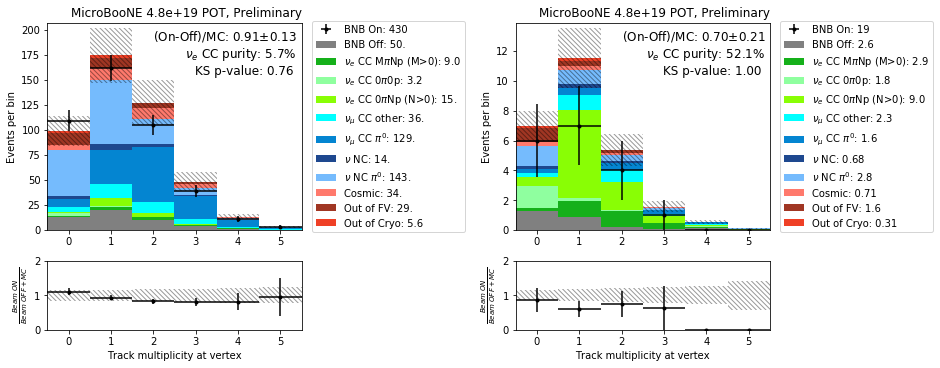

In [25]:
# number of tracks at vtx:
# closer than 4cm, trackscore>0.3, transform sum


fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_at_vtx",
    r"Track multiplicity at vertex",
    N_bins=6,
    x_min=-0.5,
    x_max=5.5,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat",
    show_syst=True,
    show_lee=False,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_at_vtx",
    r"Track multiplicity at vertex",
    N_bins=6,
    x_min=-0.5,
    x_max=5.5,
    legend=True,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat",
    show_syst=True,
    show_lee=False,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.75,
    r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
    + "\n"
    + r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)

[x.set_title("", loc="left") for x in ax[0]]
[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "trk_at_vtx.pdf", bbox_inches="tight")

In [26]:
after_e = [
    0.0724407,
    0.069931,
    0.070793,
    0.0591427,
    0.0580825,
    0.0707208,
    0.0619271,
    0.0631596,
    0.071956,
    0.0823832,
    0.076636,
    0.0799156,
    0.0945661,
    0.107033,
    0.127387,
    0.148529,
    0.0948171,
]

after_phi = [
    0.0629107,
    0.0574177,
    0.0622805,
    0.0734858,
    0.0484628,
    0.0669408,
    0.0615361,
    0.062214,
    0.098453,
    0.0704486,
    0.0610666,
    0.063518,
]
after_theta = [
    0.0631627,
    0.0555099,
    0.0535565,
    0.0719665,
    0.0884092,
    0.071224,
    0.0889857,
    0.110553,
    0.114683,
    0.0920515,
    0.132373,
    0.349061,
]

before_e = [
    0.29716,
    0.265507,
    0.24898,
    0.260043,
    0.269309,
    0.240034,
    0.263073,
    0.279628,
    0.281871,
    0.269588,
    0.269238,
    0.280828,
    0.295573,
    0.296626,
    0.265467,
    0.293,
    0.288306,
]

before_phi = [
    0.220577,
    0.266154,
    0.241005,
    0.365799,
    0.414711,
    0.245414,
    0.222696,
    0.248814,
    0.252192,
    0.220549,
    0.263487,
    0.255388,
]

before_theta = [
    0.220855,
    0.255422,
    0.287287,
    0.245846,
    0.289416,
    0.314501,
    0.323908,
    0.286917,
    0.231717,
    0.255552,
    0.282183,
    0.406976,
]

Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 2.9 	#entries 6827
MC category: $\nu_e$ CC 0$\pi$0p: 1.8 	#entries 3359
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 9.0 	#entries 17676
MC category: $\nu_{\mu}$ CC other: 2.3 	#entries 321
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 1.6 	#entries 302
MC category: $\nu$ NC: 0.68 	#entries 235
MC category: $\nu$ NC $\pi^{0}$: 2.8 	#entries 292
MC category: Cosmic: 0.71 	#entries 145
MC category: Out of FV: 1.6 	#entries 243
MC category: Out of Cryo: 0.31 	#entries 4
Systematic vatiation weightsFlux has 100 universes.
Systematic vatiation weightsGenie has 100 universes.
Ratio and purity are obtained
MC category: $\nu_e$ CC M$\pi$Np (M>0): 2.9 	#entries 6827
MC category: $\nu_e$ CC 0$\pi$0p: 1.8 	#entries 3359
MC category: $\nu_e$ CC 0$\pi$Np (N>0): 9.0 	#entries 17676
MC category: $\nu_{\mu}$ CC other: 2.3 	#entries 321
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 1.6 	#entries 302
MC category: $\nu$ NC: 0.68 	#entries 235
MC category

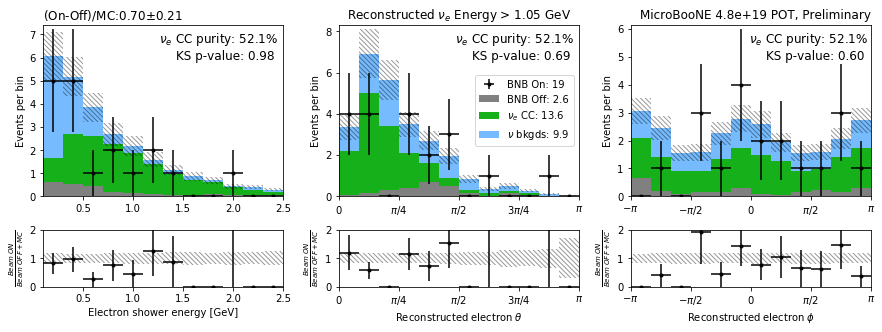

In [27]:
%autoreload
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(7.5 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_energy_y_v/1000",
    "Electron shower energy [GeV]",
    N_bins=12,
    x_min=0.1,
    x_max=2.5,
    query="(select & e_candidate)",
    legend=False,
    title_str="",
    # syst_fractions=before_e,
    kind="syst",
    show_data=True,
    show_lee=False
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_theta_v",
    r"Reconstructed electron $\theta$",
    N_bins=12,
    x_min=0.0,
    x_max=np.pi,
    query="(select & e_candidate)",
    legend=False,
    title_str="",
    kind="syst",
    # syst_fractions=before_theta,
    show_data=True,
    show_lee=False
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[1][1].set_xticks(helper.theta_ticks)
ax[1][1].set_xticklabels(helper.theta_labs)
ax[0][1].set_xticks(helper.theta_ticks)
ax[0][1].set_xticklabels(helper.theta_labs)
ax[0][1].set_title("", loc="left")
ax[0][1].set_title(r"Reconstructed $\nu_e$ Energy > 1.05 GeV")
ax[0][1].legend(loc="center right")

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_phi_v",
    "Reconstructed electron $\phi$",
    N_bins=12,
    x_min=-np.pi,
    x_max=np.pi,
    query="(select & e_candidate)",
    legend=False,
    title_str=title_str,
    kind="syst",
    # syst_fractions=before_phi,
    show_data=True,
    show_lee=False
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.98,
    ax[0][2].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1%}\nKS p-value: {1:<5.2f}".format(purity[0], ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[1][2].set_xticks(helper.phi_ticks)
ax[1][2].set_xticklabels(helper.phi_labs)
ax[0][2].set_xticks(helper.phi_ticks)
ax[0][2].set_xticklabels(helper.phi_labs)
ax[0][2].set_title("", loc="left")


_ = [x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(
    output_dir + "electron_kinematics_after.pdf", bbox_inches="tight",
)